In [11]:
import os
import glob
import re

from plotbee.video import Video
from plotbee.body import Body
import plotbee.videoplotter as vplt

import cv2
import numpy as np
import pandas as pd

from skimage import io
from datetime import datetime, timedelta

from tqdm import tqdm

import matplotlib.pyplot as plt

Body.width = 512
Body.height = 512
COLOR = [92, 82, 79]

FPS=20

COLONY="col08"
SKELETON_FOLDER=f"/mnt/storage/work/jchan/gurabo10/detections/{COLONY}"
VIDEO_FOLDER=f"/mnt/storage/Gurabo/datasets/gurabo10/mp4/{COLONY}"

SKLETON_PATTERN="hungarian_tag_*_skeleton.json"
SKLETON_RE_PATTERN="hungarian_tag_(.+?)_skeleton.json"


Body.width = 512
Body.height = 512


def get_video_id(filename):
    m = re.search(SKLETON_RE_PATTERN, filename)
    return m.group(1)


def get_video_path(video_id):
    return f"{VIDEO_FOLDER}/{video_id}.mp4"


def load_video(skeleton_path, video_path):
    video = Video.load(skeleton_path)
    video.load_video(video_path)
    return video



    
def isInCenter(body):
    x, y = body.center
    if y < 300 or y > 1100:
        return False
    if x < 400 or x > 2000:
        return False
    return True

def hasThoraxAndNeck(body):
    if (2 in body._parts) and (3 in body._parts):
        return True
    return False
        
def filter_bodies(body):
    if not hasThoraxAndNeck(body):
        return False
    if not isInCenter(body):
        return False
    return True
        
def fix_skeleton(video):
    for frame in video:
        for body in frame:
            if (2 in body._parts) and (3 in body._parts):
                body._center_part = 2
                body._angle_conn= [2, 3]
    return video

def isTrackTagged(track):
    if track.tag.mode.size > 0:
        if track._tag[0][0] != -1:
            return True
    return False

def get_bodies(track):
    bodies = list()
    for body in track:
        if body.virtual == False:
            bodies.append(body)
    return bodies


def get_body_info(body, datetime, tracks):
    info = body.info()
    frame = info["frame"]
    info["datetime"] = datetime + timedelta(seconds=frame/FPS)
    info["track_tag_id"] = tracks[body.id]._tag[0][0]
    return info

def get_video_date(filename):
    pattern  = r"hungarian_tag_(?P<seq>[0-9]+)_(?P<colony>[0-9][0-9])_R_(?P<year>[0-9][0-9])(?P<month>[0-9][0-9])(?P<day>[0-9][0-9])(?P<hour>[0-9][0-9])(?P<min>[0-9][0-9])(?P<sec>[0-9][0-9])_skeleton.json"
    pattern = re.compile(pattern)
    m = pattern.search(filename)
    date_format = ["year", "month", "day", "hour", "min", "sec"]

    YY,MM,DD,hh,mm,ss=[int(m.group(g)) for g in date_format]
    return datetime(2000+YY,MM,DD,hh,mm,ss)

def extract_dataset(filename, video_path, output_folder):
    print(filename)
    video = Video.load(filename)
    video.load_video(video_path)
    
    #get video datetime
    _, ff= os.path.split(filename)
    video_datetime = get_video_date(ff)
    folder = ff[14:-14]
    print(folder)
    print(video_datetime)
    
    os.makedirs(os.path.join(output_folder, folder), exist_ok=True)
    
    tracks = video.tracks
    
    bodies = list()
    for tid, track in tracks.items():
        if isTrackTagged(track):
            bodies += get_bodies(track)
    filtered_bodies = [body for body in bodies if filter_bodies(body)]
    print("filtered_bodies: {}".format(len(filtered_bodies)))
    csv_data = list()
    
    for i, body in enumerate(tqdm(filtered_bodies)):
        info = get_body_info(body, video_datetime, tracks)
        path = os.path.join(folder, "{:09}.jpg".format(i))
        info["filename"] = path
        save_path = os.path.join(output_folder, path)
        image = body.image
        io.imsave(save_path, image)
        csv_data.append(info)

        
    df = pd.DataFrame(csv_data)
    df.to_csv(os.path.join(output_folder, folder + ".csv"), index=False)
    return df



In [12]:
files = glob.glob(os.path.join(SKELETON_FOLDER, SKLETON_PATTERN))
video_ids = [get_video_id(f) for f in files]
videos = [get_video_path(vid) for vid in video_ids]
# for sk_file, video_file in tqdm(zip(files, videos), total=len(files)):
#     df = extract_dataset(files[1], videos[1], f"/mnt/storage/work/jchan/tag_dataset/{COLONY}")

In [13]:
i =2
video = load_video(files[i], videos[i])

100%|██████████| 72008/72008 [00:25<00:00, 2872.49it/s]


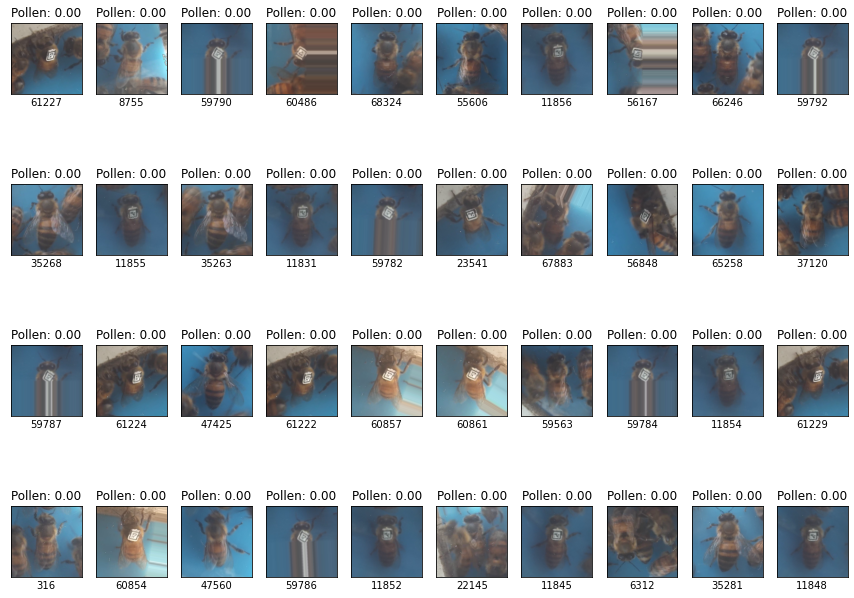

In [16]:
tagged = video.tagged()

from random import shuffle
shuffle(tagged)
vplt.contact_sheet(tagged[:40])

In [23]:
hamming_zeero_tagged = [ b  for b in tagged if b.tag["hamming"] == 0]
hamming_zeero_tagged = [b for b in hamming_zeero_tagged if isInCenter(b)]

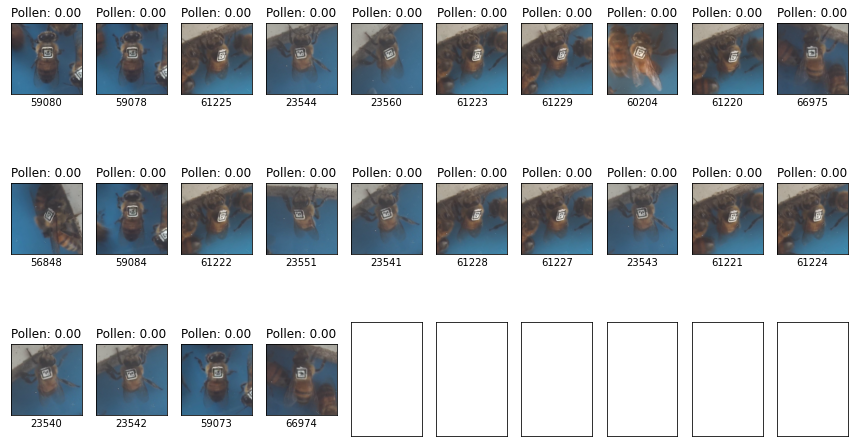

In [24]:
shuffle(hamming_zeero_tagged)
vplt.contact_sheet(hamming_zeero_tagged)